# Chapter 9: CycleGAN

# Imports

In [168]:
import torch
import torch.nn as nn
import torch.cuda as cuda
from torch.optim import Adam
from torchvision.datasets import VisionDataset, ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [169]:
BATCH_SIZE = 32

# Loading data

PyTorch or torchvision does not come with the `apple2orange` dataset. Therefore we implement a full dataset which retrieves the data.

In [170]:
class Apple2Orange(VisionDataset):
    url = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip"
    base_folder = "apple2orange"
    filename = "apple2orange.zip"
    zip_md5 = "5b58c340256288622a835d6f3b6198ae"
    
    def __init__(self, root, train=True, transform=None, target_transform=None,
             download=False):
        super().__init__(root, transform=transform,
                            target_transform=target_transform)
        self.train = train
        self.train_folder = os.path.join(self.root, self.base_folder, "train")
        self.test_folder = os.path.join(self.root, self.base_folder, "test")

        if download:
            self.download()
            
        if train:
            root = self.train_folder
        else:
            root = self.test_folder
            
        self.apples = [f for f in os.scandir(os.path.join(root, "apple")) if f.is_file()]
        self.oranges = [f for f in os.scandir(os.path.join(root, "orange")) if f.is_file()]
        
    def __getitem__(self, index):
        return self.transform(default_loader(self.apples[index])), self.transform(default_loader(self.oranges[index]))
    
    def __len__(self):
        return min(len(self.apples), len(self.oranges))
            
    def _check_integrity(self):
        fpath = os.path.join(self.root, self.filename)
        
        if check_integrity(fpath, self.zip_md5) and os.path.exists(os.path.join(self.root, self.base_folder)):
            return True
        else:
            return False
        
            
    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        
        #download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.zip_md5)
        
        train_path = os.path.join(self.root, self.base_folder, "train")
        test_path = os.path.join(self.root, self.base_folder, "test")
        source_train_a = os.path.join(self.root, self.base_folder, "trainA")
        source_train_b = os.path.join(self.root, self.base_folder, "trainB")
        source_test_a = os.path.join(self.root, self.base_folder, "testA")
        source_test_b = os.path.join(self.root, self.base_folder, "testB")
        
        os.mkdir(train_path)
        os.mkdir(test_path)
        
        os.renames(source_train_a, os.path.join(train_path, "apple"))
        os.renames(source_train_b, os.path.join(train_path, "orange"))
        os.renames(source_test_a, os.path.join(test_path, "apple"))
        os.renames(source_test_b, os.path.join(test_path, "orange"))


In [171]:
t = Compose([Resize(128), ToTensor(), Lambda(lambda x: x * 2 - 1)])
train_set = Apple2Orange('~/pytorch', train=True, download=True, transform=t)
test_set = Apple2Orange('~/pytorch', train=False, download=True, transform=t)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


# Support CUDA

In [172]:
if cuda.is_available():
    print("Using cuda device for training")
    device = 'cuda'
else:
    print("Using cpu for training")
    device = 'cpu'

Using cuda device for training


# Generator

In [182]:
class Generator(nn.Module):
    class TransSkip(nn.Module):
        def __init__(self, in_channel, out_channel, kernel_size):
            super().__init__()
            self.trans1 = nn.Sequential(
                nn.UpsamplingNearest2d(scale_factor=2),
                # nn.ZeroPad2d((2, 1, 2, 1)),
                # nn.Conv2d(in_channel, out_channel, 4, stride=1),
                nn.Conv2d(in_channel, out_channel, kernel_size, stride=1, padding=int(kernel_size/2)),
                nn.LeakyReLU(negative_slope=0.2),
                nn.InstanceNorm2d(out_channel, affine=True))
            
        def forward(self, x, skip):
            trans = self.trans1(x)
            x = torch.cat([trans,  skip], dim=1)
            
            return x

    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layer(3, 32, 3)
        self.conv2 = self.conv_layer(32, 64, 3)
        self.conv3 = self.conv_layer(64, 128, 3)
        self.conv4 = self.conv_layer(128, 256, 3)
        
        self.trans1 = self.TransSkip(256, 128, 3)
        self.trans2 = self.TransSkip(256, 64, 3)
        self.trans3 = self.TransSkip(128, 32, 3)
        # Check if using skip from first image improves result
        # self.trans4 = self.TransSkip(64, 64, 3)
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(67, 3, 3, stride=1, padding=1),
        #     nn.Tanh())
        self.trans4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh())
    
    def forward(self, x):
        skip_0 = x
        skip_1 = x = self.conv1(x)
        skip_2 = x = self.conv2(x)
        skip_3 = x = self.conv3(x)
        x = self.conv4(x)
        x = self.trans1(x, skip_3)
        x = self.trans2(x, skip_2)
        x = self.trans3(x, skip_1)
        # x = self.trans4(x, skip_0)
        x = self.trans4(x)
        x = self.conv5(x)
        
        return x
    
    def conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.InstanceNorm2d(out_channels, affine=True))

In [174]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layer(3, 64, 3)
        self.conv2 = self.conv_layer(64, 128, 3)
        self.conv3 = self.conv_layer(128, 256, 3)
        self.conv4 = self.conv_layer(256, 512, 3)
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x
    
    def conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=int(kernel_size/2)),
            nn.LeakyReLU(negative_slope=0.2),
            nn.InstanceNorm2d(out_channels, affine=True))

In [175]:
gen_AB = Generator().to(device)
gen_BA = Generator().to(device)
dis_A = Discriminator().to(device)
dis_B = Discriminator().to(device)

cycle_loss_criteria = nn.L1Loss()
adversarial_loss_criteria = nn.MSELoss()

real = torch.ones(BATCH_SIZE, 1, 9, 9).to(device)
fake = torch.zeros(BATCH_SIZE, 1, 9, 9).to(device)

dis_A_optim = Adam(dis_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_B_optim = Adam(dis_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_AB_optim = Adam(gen_AB.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_BA_optim = Adam(gen_BA.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [176]:
for epoch in range(100):
    for img_A, img_B in tqdm(train_loader):
        img_A = img_A.to(device)
        img_B = img_B.to(device)
        # A -> B
        img_B_gen = gen_AB(img_A)
        d_out = dis_B(img_B_gen)
        fake_loss = adversarial_loss_criteria(d_out, fake)

        dis_B_optim.zero_grad()
        fake_loss.backward()
        dis_B_optim.step()

        d_out = dis_B(img_B)
        real_loss = adversarial_loss_criteria(d_out, real)
        
        total_disA_loss = fake_loss + real_loss

        dis_B_optim.zero_grad()
        real_loss.backward()
        dis_B_optim.step()

        # B -> A
        img_A_gen = gen_BA(img_A)
        d_out = dis_A(img_A_gen)
        fake_loss = adversarial_loss_criteria(d_out, fake)

        dis_A_optim.zero_grad()
        fake_loss.backward()
        dis_A_optim.step()

        d_out = dis_A(img_A)
        fake_loss = adversarial_loss_criteria(d_out, real)
        
        total_disB_loss = fake_loss + real_loss

        dis_A_optim.zero_grad()
        fake_loss.backward()
        dis_A_optim.step()

        # Generator
        img_B_gen = gen_AB(img_A)
        img_A_rec = gen_BA(img_B_gen)
        d_out = dis_B(img_B_gen)
        img_B_gen2 = gen_AB(img_B)

        rec_A_loss = cycle_loss_criteria(img_A, img_A_rec) #* 10
        adv_A_loss = adversarial_loss_criteria(d_out, real)
        id_A_loss = cycle_loss_criteria(img_B, img_B_gen2) #* 9
        total_A_loss = rec_A_loss + adv_A_loss + id_A_loss

        img_A_gen = gen_BA(img_B)
        img_B_rec = gen_AB(img_A_gen)
        d_out = dis_A(img_A_gen)
        img_A_gen2 = gen_BA(img_A)

        rec_B_loss = cycle_loss_criteria(img_B, img_B_rec) #* 10
        adv_B_loss = adversarial_loss_criteria(d_out, real)
        id_B_loss = cycle_loss_criteria(img_A, img_A_gen2) #* 9
        total_B_loss = rec_B_loss + adv_B_loss + id_B_loss

        gen_AB_optim.zero_grad()
        gen_BA_optim.zero_grad()

        total_A_loss.backward()
        total_B_loss.backward()

        gen_AB_optim.step()
        gen_BA_optim.step()

    print(f"Epoch: {epoch} A_total: {total_A_loss:.4f} A_dis_fake: {adv_A_loss:.4f} A_dis_real: {total_disA_loss:.4f}")
    print(f"Epoch: {epoch} B_total: {total_B_loss:.4f} B_dis_fake: {adv_B_loss:.4f} B_dis_real: {total_disB_loss:.4f}")


Epoch: 0 A_total: 1.4202 A_dis_fake: 0.6547 A_dis_real: 0.4449
Epoch: 0 B_total: 1.3726 B_dis_fake: 0.6255 B_dis_real: 0.6350



Epoch: 1 A_total: 1.3349 A_dis_fake: 0.6362 A_dis_real: 0.3890
Epoch: 1 B_total: 1.3000 B_dis_fake: 0.6041 B_dis_real: 0.5580



Epoch: 2 A_total: 1.3500 A_dis_fake: 0.6857 A_dis_real: 0.3688
Epoch: 2 B_total: 1.1212 B_dis_fake: 0.4663 B_dis_real: 0.5608



Epoch: 3 A_total: 1.3359 A_dis_fake: 0.6677 A_dis_real: 0.3535
Epoch: 3 B_total: 1.2195 B_dis_fake: 0.5634 B_dis_real: 0.4113



Epoch: 4 A_total: 1.4115 A_dis_fake: 0.7392 A_dis_real: 0.2915
Epoch: 4 B_total: 1.1419 B_dis_fake: 0.4507 B_dis_real: 0.3975


KeyboardInterrupt: 

In [177]:
real_A, real_B = train_set[1]
real_A = real_A.to(device)
real_B = real_B.to(device)
fake_B, fake_A = gen_AB(real_A.unsqueeze(dim=0)), gen_BA(real_B.unsqueeze(dim=0))

In [178]:
real_A = (real_A + 1) / 2
real_B = (real_B + 1) / 2
fake_A = (fake_A + 1) / 2
fake_B = (fake_B + 1) / 2

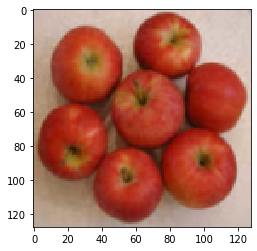

In [179]:
plt.imshow(real_A.to('cpu').permute(1,2,0))

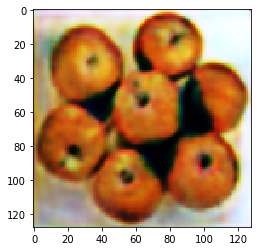

In [180]:
plt.imshow(fake_B.to('cpu').detach().squeeze().permute(1,2,0))

In [ ]:
plt.imshow(fake_B.to('cpu').detach().squeeze().permute(1,2,0))

In [ ]:
fake_A.shape

In [ ]:
rec_A = gen_BA(fake_B)

In [ ]:
rec_A = (rec_A + 1) / 2

In [ ]:
plt.imshow(rec_A.to('cpu').detach().squeeze().permute(1,2,0))